In [15]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import accuracy_score

In [16]:
# Dirs
cwd= os.getcwd()
data_dir= os.path.join(cwd, "/data/")
artifacts_dir= os.path.join(cwd, "/artifacts/")

In [17]:
transform= transforms.Compose([
    # er
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
train_dataset= datasets.CIFAR100(root= data_dir, train= True, download= True, transform= transform)
val_dataset= datasets.CIFAR100(root= data_dir, train= False, download= True, transform= transform)

In [19]:
class_names= train_dataset.classes

In [20]:
torch.manual_seed(42)
BATCH_SIZE= 64
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle= False)


In [21]:
batch= next(iter(train_loader))
batch[1].shape

torch.Size([64])

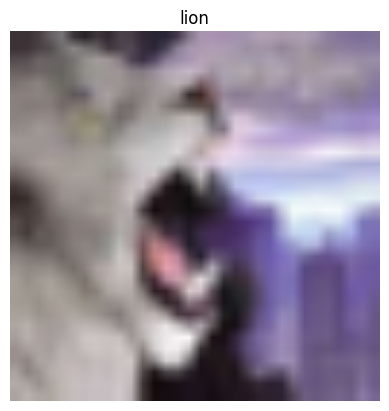

In [22]:
random_index= random.randint(0, BATCH_SIZE)
def visualize_image(input, class_names, title= None):
    input= input.numpy().transpose((1,2,0))
    mean= np.array([0.485, 0.456, 0.406])
    std= np.array([0.229, 0.224, 0.225])
    input= std * input + mean
    input= np.clip(input, 0, 1)
    plt.axis('off')
    plt.imshow(input)
    if title is not None:
        plt.title(class_names[sample_label.item()])
    plt.pause(0.001)
# Visualize random image in batch
sample_image= batch[0][random_index]
sample_label= batch[1][random_index]
visualize_image(sample_image, class_names, sample_label)

In [23]:
feature_extractor_model= models.resnet18(pretrained= True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Freeze all layers in the model
for param in feature_extractor_model.parameters():
    param.requires_grad= False

# Add new trainable fc layer
num_classes= len(class_names)
num_features= feature_extractor_model.fc.in_features
feature_extractor_model.fc= torch.nn.Linear(num_features, num_classes)


In [25]:
loss_fn= nn.CrossEntropyLoss()

In [26]:
preds= feature_extractor_model(batch[0])
class_preds= F.softmax(preds, dim= 1).argmax(dim=-1)
loss_fn(preds, batch[1])
accuracy_score(batch[1], class_preds)

0.015625

In [27]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, device, n_epochs= 15):
    # Global History
    train_loss_history= []
    train_acc_history= []
    val_loss_history= []
    val_acc_history= []

    # Early Stopping
    best_val_accuracy= 0
    min_delta= 0.5
    patience= 4
    epochs_without_improvement= 0

    model.to(device)
    for epoch in range(1, n_epochs + 1):
        # Train
        model.train()
        # Metrics setup
        running_train_loss= 0.0
        all_predictions= []
        all_labels= []

        for batch in train_loader:

            images_batch, labels_batch= batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()

            # Forward
            predictions= model(images_batch)
            loss= loss_fn(predictions, labels_batch)

            # Backward
            loss.backward()
            optimizer.step()

            # Clipping grad norms
            nn.utils.clip_grad_norm_(model.parameters(), max_norm= 3.0)

            # Metrics calculation
            running_train_loss+= loss.item()
            class_preds= F.softmax(predictions, dim= 1).argmax(dim=-1)
            all_predictions.extend(class_preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

        avg_train_loss= running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        train_epoch_accuracy= 100 * accuracy_score(all_labels, all_predictions)
        train_acc_history.append(train_epoch_accuracy)

        model.eval()
        running_val_loss= 0.0
        all_predictions= []
        all_labels= []

        with torch.no_grad():
            for batch in val_loader:
                images_batch, labels_batch= batch[0].to(device), batch[1].to(device)

                predictions= model(images_batch)
                loss= loss_fn(predictions, labels_batch)
                running_val_loss+= loss.item()

                class_preds= F.softmax(predictions, dim= 1).argmax(dim= -1)
                all_predictions.extend(class_preds.cpu().numpy())
                all_labels.extend(labels_batch.cpu().numpy())

            avg_val_loss= running_val_loss / len(val_loader)
            val_loss_history.append(avg_val_loss)

            val_epoch_accuracy= 100 * accuracy_score(all_labels, all_predictions)
            val_acc_history.append(val_epoch_accuracy)
            scheduler.step()

        print(f"Epoch: {epoch}")
        print("-"*15)
        print(f"Train Loss: {avg_train_loss:.3f} | Train Accuracy: {train_epoch_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.3f} | Val Accuracy: {val_epoch_accuracy:.2f}%")

        # Check for early stopping
        if best_val_accuracy + min_delta < val_epoch_accuracy:
            best_val_accuracy= val_epoch_accuracy
            epochs_without_improvement= 0
        else:
            epochs_without_improvement+= 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after epoch {epoch}")
            break
    training_epochs= list(range(1, epoch + 1))

    return {
        "train_loss_history": train_loss_history,
        "train_acc_history": train_acc_history,
        "val_loss_history": val_loss_history,
        "val_acc_history": val_acc_history,
        "epochs": training_epochs
    }

In [28]:
torch.manual_seed(42)
LEARNING_RATE= 0.01
NUM_EPOCHS= 15
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(feature_extractor_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)
scheduler= torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
feature_extractor_history= train_model(feature_extractor_model, train_loader, val_loader, optimizer, scheduler, loss_fn, device, NUM_EPOCHS)


Epoch: 1
---------------
Train Loss: 2.205 | Train Accuracy: 44.60%
Val Loss: 1.690 | Val Accuracy: 54.50%
Epoch: 2
---------------
Train Loss: 1.569 | Train Accuracy: 56.83%
Val Loss: 1.584 | Val Accuracy: 56.44%
Epoch: 3
---------------
Train Loss: 1.453 | Train Accuracy: 59.65%
Val Loss: 1.544 | Val Accuracy: 57.40%
Epoch: 4
---------------
Train Loss: 1.387 | Train Accuracy: 61.32%
Val Loss: 1.499 | Val Accuracy: 58.84%
Epoch: 5
---------------
Train Loss: 1.328 | Train Accuracy: 63.07%
Val Loss: 1.524 | Val Accuracy: 58.06%
Epoch: 6
---------------
Train Loss: 1.285 | Train Accuracy: 63.69%
Val Loss: 1.508 | Val Accuracy: 58.80%
Epoch: 7
---------------
Train Loss: 1.252 | Train Accuracy: 64.58%
Val Loss: 1.495 | Val Accuracy: 58.95%
Epoch: 8
---------------
Train Loss: 1.227 | Train Accuracy: 65.57%
Val Loss: 1.475 | Val Accuracy: 59.22%
Early stopping triggered after epoch 8
